<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Deploy a model in the cloud - P8</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Notebook - Proof of Concept |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries & static variables</h2>
</div>

In [1]:
## General
import os
import io
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

## To connect with S3 files
import botocore.session
import boto3

## Spark
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (split, col, pandas_udf,
                                   PandasUDFType, udf)
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StandardScaler, PCA

## Tensorflow 
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

2022-03-06 18:57:38.485827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-06 18:57:38.485876: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BUCKET = "oc-p8-bucket"
SUBFOLDER = "test/images/"
RESULT = "result"
DUMMY_FILE = "SampleCSVFile_556kb.csv"

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Testing connection to S3</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to print the name of the first 5 elements in the S3.</p>
</div>

In [3]:
conn = boto3.client("s3")

In [4]:
contents = conn.list_objects(Bucket=BUCKET)["Contents"]
for k in list(contents)[:5]:
    print(k["Key"])

SampleCSVFile_556kb.csv
result/
test/
test/images/
test/images/Apricot/0_100.jpg


<div class="alert alert-block alert-info">
    <p>Now, we are going to test whether we can read an image from S3.</p>
</div>

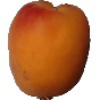

In [5]:
test_img = Image.open(
            io.BytesIO(
                conn.get_object(
                    Bucket=BUCKET,
                    Key=list(contents)[5]["Key"])["Body"].read()
                )
    )

test_img

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Spark session</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Let's setup Spark</p>
</div>

In [6]:
session = botocore.session.get_session()
credentials = session.get_credentials()
region = (boto3.session.Session()).region_name

In [7]:
# os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell"
# os.environ["PYSPARK_SUBMIT_ARGS"]= "--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-common:2.7.2,org.apache.hadoop:hadoop-client:2.7.2,org.apache.hadoop:hadoop-aws:2.7.2,com.amazonaws:aws-java-sdk-bundle:1.11.874,com.google.guava:guava:27.1-jre,databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell"

In [8]:
spark = (
    SparkSession
    .builder
    .appName("P8-FRUITS")
    .getOrCreate()
)

spark

# spark = (
#     SparkSession.builder
#     .master("local[*]")
#     .appName("P8-FRUITS")
#     .config("spark.driver.memory", "16g")
#     .config("spark.hadoop.fs.s3a.access.key", credentials.access_key)
#     .config("spark.hadoop.fs.s3a.secret.key", credentials.secret_key)
#     .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
#     .getOrCreate()
# )

22/03/06 18:57:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<div class="alert alert-block alert-info">
    <p>Let's setup the aws information</p>
</div>

In [9]:
sc = spark.sparkContext._jsc.hadoopConfiguration()
sc.set("fs.s3a.awsAccessKeyId", credentials.access_key)
sc.set("fs.s3a.awsSecretAccessKey", credentials.secret_key)
sc.set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
sc.set("fs.s3a.impl","org.apache.hadoop.fs.s3native.NativeS3FileSystem")
sc.set("com.amazonaws.services.s3.enableV4", "true")
sc.set("fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.BasicAWSCredentialsProvider")
sc.set("fs.s3a.endpoint", region + ".amazonaws.com")

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1 Testing connection to S3 with Spark</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to test the connection with Spark to our bucket. To do that, we are going to read a sample csv.</p>
</div>

In [10]:
data_location = "s3a://{}/{}".format(BUCKET, DUMMY_FILE)

In [11]:
df_dummy = spark.read.csv(data_location, header="False", inferSchema=True)
df_dummy = df_dummy.drop("1")

In [12]:
df_dummy.limit(5).toPandas()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9
0,1,"Eldon Base for stackable storage shelf, platinum",Muhammed MacIntyre,3,-213.25,38.94,35,Nunavut,Storage & Organization,0.8
1,2,"""1.7 Cubic Foot Compact """"Cube"""" Office Refrig...",Barry French,293,457.81,208.16,68.02,Nunavut,Appliances,0.58
2,3,"Cardinal Slant-D� Ring Binder, Heavy Gauge Vinyl",Barry French,293,46.71,8.69,2.99,Nunavut,Binders and Binder Accessories,0.39
3,4,R380,Clay Rozendal,483,1198.97,195.99,3.99,Nunavut,Telephones and Communication,0.58
4,5,Holmes HEPA Air Purifier,Carlos Soltero,515,30.94,21.78,5.94,Nunavut,Appliances,0.5


In [13]:
df_dummy.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)



<div class="alert alert-block alert-success">
    <p>Great!, we can access to S3 from ours Notebook through Spark / Pyspark</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2 Testing reading an image from S3 through Spark</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, let's try to read an image from the bucket</p>
</div>

In [14]:
image = spark.read.format("image").load("s3a://{}/{}".format(BUCKET, list(contents)[5]["Key"]))

In [15]:
image.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [16]:
image.show()

+--------------------+
|               image|
+--------------------+
|[s3a://oc-p8-buck...|
+--------------------+



In [17]:
img = image.first()

In [18]:
img = np.array(img.asDict()["image"]["data"]).reshape(100, 100, 3)[:, :, ::-1]

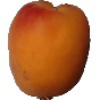

In [19]:
Image.fromarray(img, "RGB")

<div class="alert alert-block alert-success">
    <p>So far, We have access to an image. Let's go to read all images in the bucket.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Reading images with Spark</h2>
</div>

<div class="alert alert-block alert-info">
    <p>To read the images, we will restrict the format only to *.jpg. In addition, we will read all subdirectories in the main directory.</p>
</div>

In [20]:
df_images = spark.read.format("binaryfile")\
      .option("recursiveFileLookup", "true")\
      .load("s3a://{}/{}/*".format(BUCKET, SUBFOLDER))

# df_images = spark.read.format("binaryfile")\
#       .option("pathGlobFilter", "*.jpg")\
#       .option("recursiveFileLookup", "true")\
#       .load("s3a://{}/{}/*".format(BUCKET, SUBFOLDER))

In [21]:
df_images.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [22]:
df_images.show(5)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://oc-p8-bucke...|2022-02-28 09:03:42|  7415|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...|2022-02-28 09:03:41|  7314|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...|2022-02-28 09:03:06|  7178|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...|2022-02-28 09:03:40|  7089|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...|2022-02-28 09:03:13|  6823|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows



<div class="alert alert-block alert-info">
    <p>Let's just save the interested variables for each image.</p>
</div>

In [23]:
df_images = df_images.withColumn("category", split(col("path"), "/").getItem(5))
df_images = df_images.select("path", "category", "content")
df_images.printSchema()

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)



In [24]:
df_images.show(5)

+--------------------+----------+--------------------+
|                path|  category|             content|
+--------------------+----------+--------------------+
|s3a://oc-p8-bucke...| Raspberry|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...| Raspberry|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...| Raspberry|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...| Raspberry|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...|Watermelon|[FF D8 FF E0 00 1...|
+--------------------+----------+--------------------+
only showing top 5 rows



<div class="alert alert-block alert-success">
    <p>Now, we have only the interested variables of each image.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Featurization for transfer learning</h2>
</div>

<div class="alert alert-block alert-info">
    <p>So far, we could read the images from out bucket (S3) through Spark.<br>
    Now, we are going to extract the features based on a pre-trained TensorFlow model. <br>
    To do that, We are going to base ourselves on the approach made by <a href="https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html", target="blank">Databricks</a></p>
</div>

In [25]:
model = ResNet50(include_top=False)

2022-03-06 18:58:06.882800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-06 18:58:06.883631: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-06 18:58:06.883670: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-80-208): /proc/driver/nvidia/version does not exist
2022-03-06 18:58:06.885284: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

In [27]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    
    return model

In [28]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    
    return preprocess_input(arr)

In [29]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    
    return pd.Series(output)

In [30]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
    
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    """
    
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/opt/spark/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [31]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [32]:
df_features = df_images.repartition(16).select(col("path"), col("category"), featurize_udf("content").alias("features"))
# df_features = df_images.select(col("path"), col("category"))
df_features.printSchema()
df_features.show()

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



2022-03-06 18:58:17.246211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-06 18:58:17.246253: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-06 18:58:19.195825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-06 18:58:19.195868: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-06 18:58:19.195894: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-80-208): /proc/driver/nvidia/version does not exist
2022-03-06 18:58:19.196114: I tensorflow/core/platform/cpu_f

+--------------------+----------+--------------------+
|                path|  category|            features|
+--------------------+----------+--------------------+
|s3a://oc-p8-bucke...| Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|      Kiwi|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|  Maracuja|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|  Maracuja|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|     Lemon|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|     Lemon|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|      Kiwi|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|Watermelon|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|     Lemon|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|   Avocado|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|    Banana|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|    Banana|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...| Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...| Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-bucke...|   Apricot|[0.0, 0.0, 0.0, 0...|
|s3a://oc-

<div class="alert alert-block alert-success">
    <p>We have achieved to make the feature extraction.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. PCA - Principal Components Analysis</h2>
</div>

In [33]:
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
df_features = df_features.select(col("path"),  col("category"), to_vector(df_features["features"]).alias("features"))

In [34]:
pca = PCA(k=7, inputCol="features", outputCol="pca_features")

In [35]:
model_pca = pca.fit(df_features)

2022-03-06 18:58:54.497155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-06 18:58:54.500086: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-06 18:58:58.538524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-06 18:58:58.538580: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-06 18:58:58.538611: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-80-208): /proc/driver/nvidia/version does not exist
2022-03-06 18:58:58.538825: I tensorflow/core/platform/cpu_f

In [36]:
pca_features = model_pca.transform(df_features)

In [37]:
pca_features.printSchema()

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



In [38]:
pca_features.show(8) 

22/03/06 19:32:55 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/03/06 19:33:22 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


+--------------------+----------+--------------------+--------------------+
|                path|  category|            features|        pca_features|
+--------------------+----------+--------------------+--------------------+
|s3a://oc-p8-bucke...| Raspberry|[0.0,0.0,0.0,0.0,...|[-65.283772526542...|
|s3a://oc-p8-bucke...|      Kiwi|[0.0,0.0,0.0,0.0,...|[-128.44461315439...|
|s3a://oc-p8-bucke...|  Maracuja|[0.0,0.0,0.0,0.0,...|[-123.14722624830...|
|s3a://oc-p8-bucke...|  Maracuja|[0.0,0.0,0.0,0.0,...|[-89.397973720309...|
|s3a://oc-p8-bucke...|     Lemon|[0.0,0.0,0.0,0.0,...|[-146.80115569649...|
|s3a://oc-p8-bucke...|     Lemon|[0.0,0.0,0.0,0.0,...|[-144.93317239358...|
|s3a://oc-p8-bucke...|      Kiwi|[0.0,0.0,0.0,0.0,...|[-157.56743129287...|
|s3a://oc-p8-bucke...|Watermelon|[0.0,0.0,0.0,0.0,...|[-84.156082416864...|
+--------------------+----------+--------------------+--------------------+
only showing top 8 rows



<div class="alert alert-block alert-info">
    <p>Let's plot the % of inertia (variance) based on the principal components.</p>
</div>

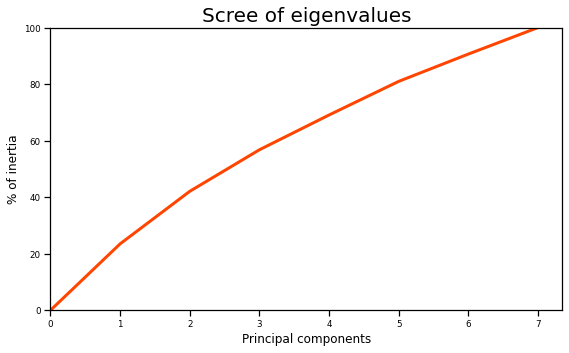

In [64]:
scree = model_pca.explainedVariance.cumsum()

fig = plt.subplots(figsize=(8, 5))
sns.set_context(context="notebook", rc={"lines.linewidth": 3}, font_scale=0.8)
sns.lineplot(x=[i for i in range(8)], y=np.insert(var, 0, 0)*100, color="orangered")
plt.xlabel("Principal components", size=12)
plt.ylabel("% of inertia", size=12)
plt.title("Scree of eigenvalues", size=20)
plt.ylim(0, 100)
plt.xlim(left=0)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    <p>Let's save the PCA results as *.csv into our S3.</p>
</div>

In [65]:
df_final = pca_features.select("path", "category", "pca_features")

In [66]:
df_final_pd = df_final.toPandas()

22/03/06 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
2022-03-06 21:01:45.086997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-06 21:01:45.086997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-06 21:01:45.091000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-06 21:01:45.091032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-06 21:01:54.369756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1';

In [69]:
df_final_pd.to_csv("s3a://{}/{}/{}".format(BUCKET, RESULT, "P7_PCA_result.csv"))